<a href="https://colab.research.google.com/github/PurveshBaghele/ML/blob/master/roadSignClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [4]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import random


Using TensorFlow backend.


In [0]:
np.random.seed(0)

In [7]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data = pickle.load(f)

with open('german-traffic-signs/valid.p','rb') as f:
  val_data = pickle.load(f)
  
with open('german-traffic-signs/test.p','rb') as f:
  test_data = pickle.load(f)
  
X_train, Y_train =train_data['features'],train_data['labels']
X_val, Y_val =val_data['features'],val_data['labels']
X_test, Y_test =test_data['features'],test_data['labels']
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

  

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

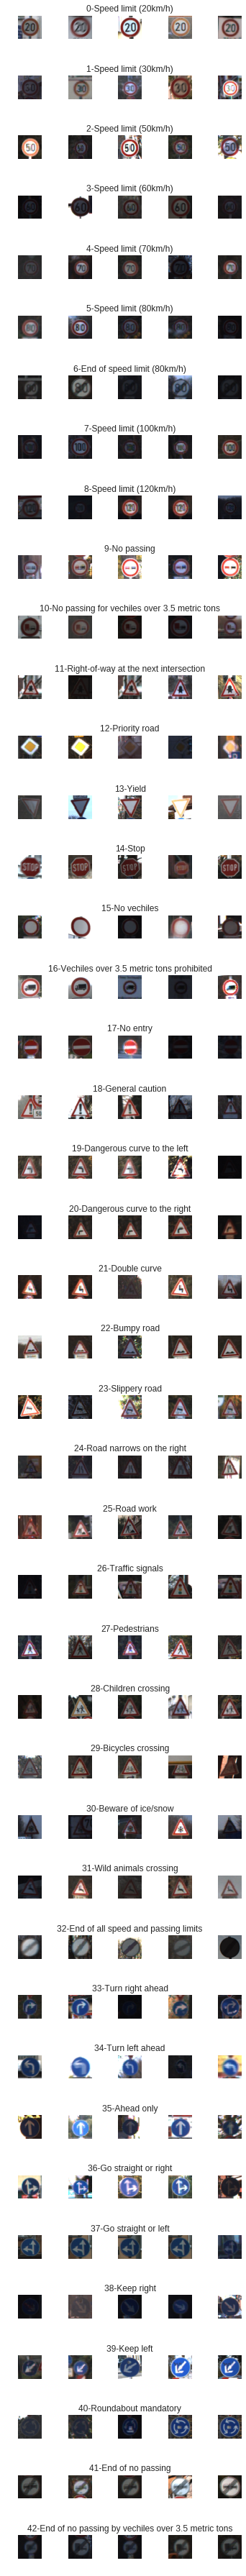

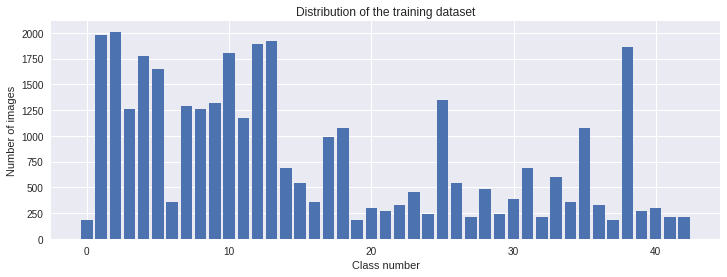

In [8]:
data =pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()

for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[Y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ '-'+ row['SignName'])
            num_of_samples.append(len(x_selected))


print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(34799, 32, 32, 3)
23


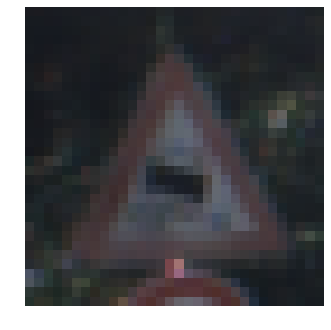

In [9]:
import cv2

plt.imshow(X_train[2002])
plt.axis('off')
print(X_train.shape)
print(Y_train[2002])

In [0]:
#preprocessing starts here

def grayscale(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img

#histogram equalization enhances contrast of the image which helps in better feature extraction
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

def preprocessing(img):
  img = equalize(grayscale(img))
  img = img/255
  return img

In [11]:
'''img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis('off')
'''



"img = grayscale(X_train[1000])\nplt.imshow(img)\nplt.axis('off')\n"

In [12]:
'''img = equalize(img)
plt.imshow(img)
plt.axis('off')
'''

"img = equalize(img)\nplt.imshow(img)\nplt.axis('off')\n"

In [0]:
X_train = np.array(list(map(preprocessing,X_train)))
X_val = np.array(list(map(preprocessing,X_val)))
X_test = np.array(list(map(preprocessing,X_test)))

(-0.5, 31.5, 31.5, -0.5)

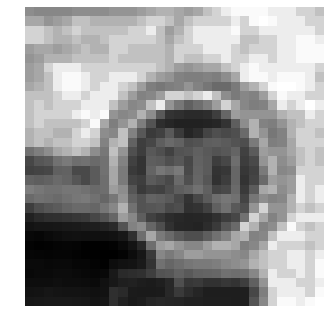

In [14]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')


In [0]:
X_train = X_train.reshape(34799,32,32,1)
X_test = X_test.reshape(12630,32,32,1)
X_val = X_val.reshape(4410,32,32,1)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                  height_shift_range=0.1,
                  zoom_range=0.2,
                  shear_range=0.1,
                  rotation_range=10)

datagen.fit(X_train)

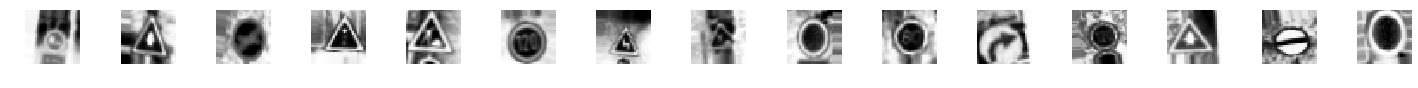

In [17]:
batches = datagen.flow(X_train,Y_train,batch_size=20)
X_batch,Y_batch = next(batches) 

fig,axs = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')

In [0]:
Y_train = to_categorical(Y_train,43)
Y_val = to_categorical(Y_val,43)
Y_test = to_categorical(Y_test,43)

In [0]:
#creation of model

def leNet_model():
  model = Sequential()
  model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Conv2D(30, (3,3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  
  model.add(Flatten())
  model.add(Dense(500,activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43,activation = 'softmax'))
  
  model.compile(Adam(0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  return model
  

In [0]:

def modified_leNet_model():
  model = Sequential()
  
  model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation = 'relu'))
  model.add(Conv2D(60, (5,5), activation = 'relu'))
  
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Conv2D(30, (3,3), activation = 'relu'))
  model.add(Conv2D(30, (3,3), activation = 'relu'))
  
  
  model.add(MaxPooling2D(pool_size=(2,2)))
 # model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(500,activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43,activation = 'softmax'))
  
  model.compile(Adam(0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  return model
  

In [25]:
model = modified_leNet_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 480)               0         
__________

In [26]:
history = model.fit_generator(datagen.flow(X_train,Y_train,batch_size = 50),steps_per_epoch=2000,epochs=10,validation_data=(X_val,Y_val),shuffle=1)

Epoch 1/10
2000/2000 [==============================] - 51s 25ms/step - loss: 0.9424 - acc: 0.7231 - val_loss: 0.0912 - val_acc: 0.9723
Epoch 2/10
2000/2000 [==============================] - 51s 25ms/step - loss: 0.2378 - acc: 0.9266 - val_loss: 0.0699 - val_acc: 0.9771
Epoch 3/10
2000/2000 [==============================] - 51s 26ms/step - loss: 0.1601 - acc: 0.9505 - val_loss: 0.0688 - val_acc: 0.9791
Epoch 4/10
2000/2000 [==============================] - 52s 26ms/step - loss: 0.1291 - acc: 0.9601 - val_loss: 0.0425 - val_acc: 0.9880
Epoch 5/10
2000/2000 [==============================] - 51s 26ms/step - loss: 0.1047 - acc: 0.9675 - val_loss: 0.0314 - val_acc: 0.9902
Epoch 6/10
2000/2000 [==============================] - 51s 26ms/step - loss: 0.0931 - acc: 0.9715 - val_loss: 0.0216 - val_acc: 0.9941
Epoch 7/10
2000/2000 [==============================] - 51s 25ms/step - loss: 0.0814 - acc: 0.9749 - val_loss: 0.0300 - val_acc: 0.9932
Epoch 8/10
2000/2000 [==========================

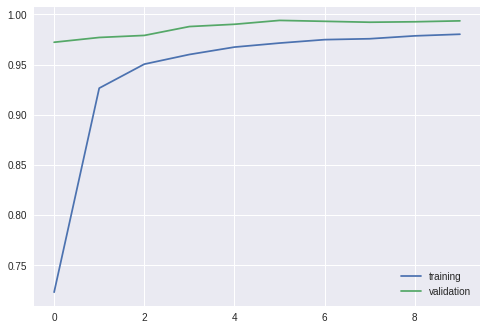

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training','validation'])


In [28]:
score = model.evaluate(X_test,Y_test,verbose=1)
print('Test score: ',score[0])
print('Accuracy: ',score[1])

12630/12630 [==============================] - 2s 132us/step
Test score:  0.12549260935993517
Accuracy:  0.9722090261754589


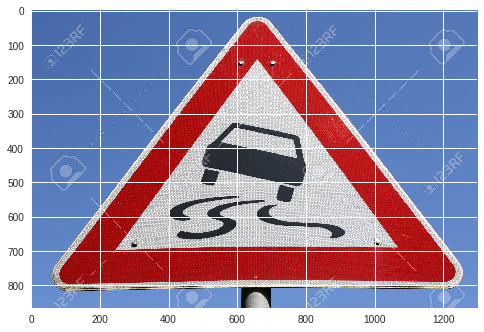

In [50]:
#fetch image

import requests
from PIL import Image
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
rr = requests.get(url, stream=True)
img = Image.open(rr.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))




(32, 32)


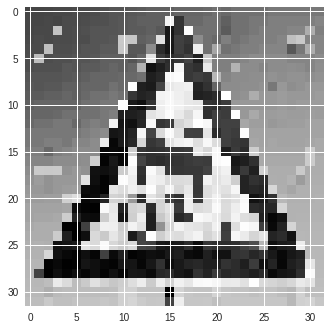

In [51]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)



In [52]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

#Test image
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [23]
